# CS6220 HW3: Random Forest Experiments

In [37]:
# Standard libraries
import time
import heapq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

## 1. Read in Bank Marketing Dataset

In [2]:
data = pd.read_csv('./data/bank.csv')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 2. Data Preprocessing

In [4]:
# Check for any null/NAN values in the features
data[data.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

### Categorical Feature Modification and Encoding (Preparing our data for the model)

In [5]:
def combine_jobs(data):
    '''
    Combine professions into a set of parent professions (white collar, pink collar, blue collar, etc.)
    '''
    # Extract each unique job value
    jobs = data.job.unique()
    jobs_count = data.job.value_counts()
    '''
    Iterate through and compute the ratio of people in a particular
    profession who have made a deposit.
    '''
#     for job in jobs:
#         print("{:15} : {:5}"
#               .format(job, len(data[(data.deposit == "yes") & (data.job == job)]) / jobs_count[job]))
        
    # Define the different 'parent' professions. Inspiration from blue collar
    white_collar = ['management', 'admin.', 'entrepreneur']
    pink_collar = ['services','housemaid']
    blue_collar = ['technician']
    others = ['retired', 'student', 'self-employed', 'unemployed', 'unknown']
    
    # Replace each of the above professions with their parent profession
    data['job'] = data['job'].replace(white_collar, 'white-collar')
    data['job'] = data['job'].replace(blue_collar, 'blue-collar')
    data['job'] = data['job'].replace(pink_collar, 'pink-collar')
    data['job'] = data['job'].replace(others, 'other')
    
#     print(data.job.value_counts())

In [6]:
def drop_contact_vars(data):
    '''
    Drop columns related to any contact-related information that don't play a role in classification.
    '''
    # Drop the 'contact' column
    columns_to_drop = ['contact', 'month', 'day']
    for column in columns_to_drop:
        data.drop(column, axis=1, inplace=True)

In [7]:
def encode_binary_variables(data):
    '''
    Encode binary categorical variables to their numeric equivalents.
    '''
    binary_variables = ['default', 'housing', 'loan', 'deposit']
    for binary_variable in binary_variables:
        data[binary_variable + '_cat'] = data[binary_variable].map({'yes': 1, 'no': 0})
        data.drop(binary_variable, axis=1, inplace=True)
        
#     for binary_variable in binary_variables:
#         print(data[binary_variable + '_cat'].value_counts())

In [8]:
def remove_negative_pdays(data):
    '''
    pdays: number of days that passed by after the client was last contacted from a previous campaign
    -1 means client was not previously contacted
    '''
#     print("Customers that have not been contacted before:", len(data[data.pdays==-1]))
#     print("Maximum values on padys    :", data.pdays.max())
    
    # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
    data.loc[data.pdays == -1, 'pdays'] = 10000

def normalize_pdays(data):
    # Create a new column: recent_pdays (MOVE INTO PREV CELL)
    data['recent_pdays'] = np.where(data['pdays'], 1/data.pdays, 1/data.pdays)

    # Drop 'pdays'
    data.drop('pdays', axis=1, inplace = True)

In [9]:
combine_jobs(data)
drop_contact_vars(data)
encode_binary_variables(data)
remove_negative_pdays(data)
normalize_pdays(data)

<AxesSubplot:xlabel='job', ylabel='deposit_cat'>

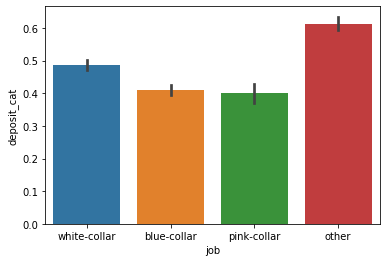

In [10]:
sns.barplot(x='job', y = 'deposit_cat', data=data)

In [11]:
# def one_hot_encode(data):
columns = ['job', 'marital', 'education', 'poutcome']
data = pd.get_dummies(data=data, columns = columns, prefix = ['job', 'marital', 'education', 'poutcome'])

In [12]:
data.head()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,recent_pdays,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,1042,1,0,0,1,0,1,0.0001,...,1,0,0,1,0,0,0,0,0,1
1,56,45,1467,1,0,0,0,0,1,0.0001,...,1,0,0,1,0,0,0,0,0,1
2,41,1270,1389,1,0,0,1,0,1,0.0001,...,1,0,0,1,0,0,0,0,0,1
3,55,2476,579,1,0,0,1,0,1,0.0001,...,1,0,0,1,0,0,0,0,0,1
4,54,184,673,2,0,0,0,0,1,0.0001,...,1,0,0,0,1,0,0,0,0,1


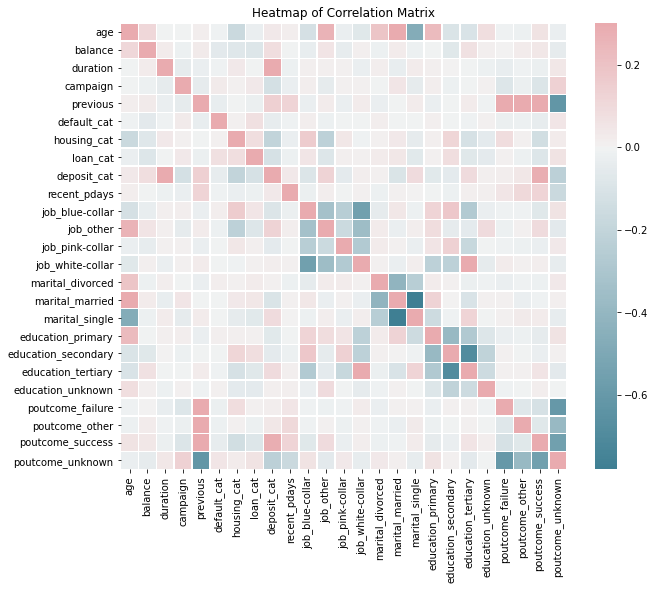

In [13]:
correlation_matrix = data.corr()

def plot_correlation_matrix(data):
    '''
    Plots the correlation matrix and visualize it using Seaborn's heatmap feature.
    '''
    # Plotting the correlation matrix using a heatmap
    plt.figure(figsize = (10,10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns.values, yticklabels=correlation_matrix.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
    plt.title('Heatmap of Correlation Matrix')
    
plot_correlation_matrix(data)

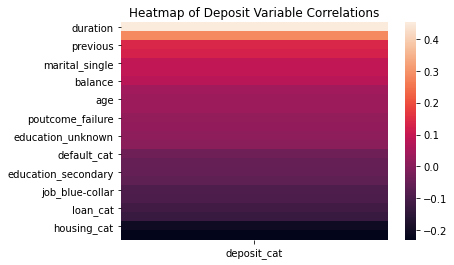

In [14]:
DEPOSIT_COLUMN = 'deposit_cat'
def plot_deposit_correlations(data):
    '''
    Isolates the deposit columns of the correlation matrix and visualize it.
    '''
    deposit_correlation_column = pd.DataFrame(correlation_matrix[DEPOSIT_COLUMN].drop(DEPOSIT_COLUMN))
    deposit_correlation_column = deposit_correlation_column.sort_values(by=DEPOSIT_COLUMN, ascending=False)
    sns.heatmap(deposit_correlation_column)
    plt.title('Heatmap of Deposit Variable Correlations')
    
plot_deposit_correlations(data)

## 3. Model Training

In [15]:
labels = data[DEPOSIT_COLUMN]
data.drop(DEPOSIT_COLUMN, axis=1, inplace=True)

### 3.1 Training a Single Decision Tree on the Dataset

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=50)

In [28]:
decision_tree_classifier = DecisionTreeClassifier(random_state=1, max_depth=6)
start = time.time()
decision_tree_classifier.fit(X_train, y_train)
end = time.time()
print(f'Training time: {end - start}s')

Training time: 0.024829864501953125s


In [29]:
# Compute our training and test accuracy
training_score = decision_tree_classifier.score(X_train, y_train)
test_score = decision_tree_classifier.score(X_test, y_test)

print('Training score: ', training_score)
print('Test score: ', test_score)

Training score:  0.8080412140217269
Test score:  0.7801164352888491


### 3.2 Training the Random Forest on the Dataset

In [30]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=6, criterion='gini', random_state=50)
start = time.time()
rf_classifier.fit(X_train, y_train)
end = time.time()
print(f'Training time: {end - start}s')

Training time: 0.3667442798614502s


In [41]:
def test_accuracy_report(classifier):
    '''
    Generate a report on how the best classifier performs on the test set.
    '''
    y_pred_train = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    print('Train Accuracy score of best classifier: ', accuracy_score(y_train, y_pred_train))
    print('Test Accuracy score of best classifier: ', accuracy_score(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

In [42]:
test_accuracy_report(rf_classifier)

Train Accuracy score of best classifier:  0.8175607570836599
Test Accuracy score of best classifier:  0.800268696820421


0.800268696820421

### 3.3 Retrieving the top-10 best and worst performing trees for the Random Forest model

In [48]:
top_10 = []
bottom_10 = []

for cl in rf_classifier.estimators_:
    heapq.heappush(bottom_10, test_accuracy_report(cl))
    heapq.heappush(top_10, test_accuracy_report(cl) * -1)

Train Accuracy score of best classifier:  0.7517079180199351
Test Accuracy score of best classifier:  0.7339901477832512
Train Accuracy score of best classifier:  0.7517079180199351
Test Accuracy score of best classifier:  0.7339901477832512
Train Accuracy score of best classifier:  0.7167655952514279
Test Accuracy score of best classifier:  0.6990595611285266
Train Accuracy score of best classifier:  0.7167655952514279
Test Accuracy score of best classifier:  0.6990595611285266
Train Accuracy score of best classifier:  0.7946018591107626
Test Accuracy score of best classifier:  0.7801164352888491
Train Accuracy score of best classifier:  0.7946018591107626
Test Accuracy score of best classifier:  0.7801164352888491
Train Accuracy score of best classifier:  0.7660432299249637
Test Accuracy score of best classifier:  0.7487684729064039
Train Accuracy score of best classifier:  0.7660432299249637
Test Accuracy score of best classifier:  0.7487684729064039
Train Accuracy score of best cla

Train Accuracy score of best classifier:  0.7723149288834136
Test Accuracy score of best classifier:  0.7514554411106136
Train Accuracy score of best classifier:  0.6562884981520887
Test Accuracy score of best classifier:  0.6318853560232871
Train Accuracy score of best classifier:  0.6562884981520887
Test Accuracy score of best classifier:  0.6318853560232871
Train Accuracy score of best classifier:  0.7123978049053645
Test Accuracy score of best classifier:  0.6923421406180027
Train Accuracy score of best classifier:  0.7123978049053645
Test Accuracy score of best classifier:  0.6923421406180027
Train Accuracy score of best classifier:  0.7540598051293538
Test Accuracy score of best classifier:  0.7366771159874608
Train Accuracy score of best classifier:  0.7540598051293538
Test Accuracy score of best classifier:  0.7366771159874608
Train Accuracy score of best classifier:  0.7782506439690895
Test Accuracy score of best classifier:  0.7559337214509628
Train Accuracy score of best cla

Train Accuracy score of best classifier:  0.8014335311905029
Test Accuracy score of best classifier:  0.7904164800716524
Train Accuracy score of best classifier:  0.8014335311905029
Test Accuracy score of best classifier:  0.7904164800716524
Train Accuracy score of best classifier:  0.7568596707358047
Test Accuracy score of best classifier:  0.7335423197492164
Train Accuracy score of best classifier:  0.7568596707358047
Test Accuracy score of best classifier:  0.7335423197492164
Train Accuracy score of best classifier:  0.7836263859334752
Test Accuracy score of best classifier:  0.7653381101656964
Train Accuracy score of best classifier:  0.7836263859334752
Test Accuracy score of best classifier:  0.7653381101656964
Train Accuracy score of best classifier:  0.7210213909732333
Test Accuracy score of best classifier:  0.7066726377071205
Train Accuracy score of best classifier:  0.7210213909732333
Test Accuracy score of best classifier:  0.7066726377071205
Train Accuracy score of best cla

In [49]:
print('---TOP 10---')
for i in range(10):
    print(f'{i+1}: {heapq.heappop(top_10) * -1}')

---TOP 10---
1: 0.7908643081056874
2: 0.7904164800716524
3: 0.7890729959695477
4: 0.7819077474249888
5: 0.7801164352888491
6: 0.7783251231527094
7: 0.7774294670846394
8: 0.7756381549484997
9: 0.77384684281236
10: 0.7707120465741155


In [50]:
print('---BOTTOM 10---')
for i in range(10):
    print(f'{i+1}: {heapq.heappop(bottom_10)}')

---BOTTOM 10---
1: 0.6318853560232871
2: 0.6318853560232871
3: 0.6336766681594268
4: 0.6390506045678459
5: 0.6426332288401254
6: 0.6439767129422301
7: 0.6444245409762651
8: 0.6502463054187192
9: 0.6538289296909987
10: 0.6569637259292431


### 3.4 Increasing the number of estimators for the Random Forest

#### 150

In [59]:
rf_classifier = RandomForestClassifier(n_estimators=150, max_depth=6, criterion='gini', random_state=50)
start = time.time()
rf_classifier.fit(X_train, y_train)
end = time.time()
print(f'Training time: {end - start}s')

Training time: 0.5370609760284424s


In [60]:
test_accuracy_report(rf_classifier)

Train Accuracy score of best classifier:  0.8167767947138538
Test Accuracy score of best classifier:  0.7975817286162113


0.7975817286162113

In [61]:
top_10 = []
bottom_10 = []

for cl in rf_classifier.estimators_:
    heapq.heappush(bottom_10, test_accuracy_report(cl))
    heapq.heappush(top_10, test_accuracy_report(cl) * -1)

Train Accuracy score of best classifier:  0.7517079180199351
Test Accuracy score of best classifier:  0.7339901477832512
Train Accuracy score of best classifier:  0.7517079180199351
Test Accuracy score of best classifier:  0.7339901477832512
Train Accuracy score of best classifier:  0.7167655952514279
Test Accuracy score of best classifier:  0.6990595611285266
Train Accuracy score of best classifier:  0.7167655952514279
Test Accuracy score of best classifier:  0.6990595611285266
Train Accuracy score of best classifier:  0.7946018591107626
Test Accuracy score of best classifier:  0.7801164352888491
Train Accuracy score of best classifier:  0.7946018591107626
Test Accuracy score of best classifier:  0.7801164352888491
Train Accuracy score of best classifier:  0.7660432299249637
Test Accuracy score of best classifier:  0.7487684729064039
Train Accuracy score of best classifier:  0.7660432299249637
Test Accuracy score of best classifier:  0.7487684729064039
Train Accuracy score of best cla

Train Accuracy score of best classifier:  0.7615634449546422
Test Accuracy score of best classifier:  0.7402597402597403
Train Accuracy score of best classifier:  0.7850823160488296
Test Accuracy score of best classifier:  0.7666815942678011
Train Accuracy score of best classifier:  0.7850823160488296
Test Accuracy score of best classifier:  0.7666815942678011
Train Accuracy score of best classifier:  0.7723149288834136
Test Accuracy score of best classifier:  0.7514554411106136
Train Accuracy score of best classifier:  0.7723149288834136
Test Accuracy score of best classifier:  0.7514554411106136
Train Accuracy score of best classifier:  0.6562884981520887
Test Accuracy score of best classifier:  0.6318853560232871
Train Accuracy score of best classifier:  0.6562884981520887
Test Accuracy score of best classifier:  0.6318853560232871
Train Accuracy score of best classifier:  0.7123978049053645
Test Accuracy score of best classifier:  0.6923421406180027
Train Accuracy score of best cla

Train Accuracy score of best classifier:  0.7084779930563333
Test Accuracy score of best classifier:  0.6833855799373041
Train Accuracy score of best classifier:  0.7373726061149065
Test Accuracy score of best classifier:  0.7241379310344828
Train Accuracy score of best classifier:  0.7373726061149065
Test Accuracy score of best classifier:  0.7241379310344828
Train Accuracy score of best classifier:  0.7839623698062493
Test Accuracy score of best classifier:  0.7698163905060457
Train Accuracy score of best classifier:  0.7839623698062493
Test Accuracy score of best classifier:  0.7698163905060457
Train Accuracy score of best classifier:  0.6901108746780155
Test Accuracy score of best classifier:  0.671294223018361
Train Accuracy score of best classifier:  0.6901108746780155
Test Accuracy score of best classifier:  0.671294223018361
Train Accuracy score of best classifier:  0.7782506439690895
Test Accuracy score of best classifier:  0.7586206896551724
Train Accuracy score of best class

Test Accuracy score of best classifier:  0.7671294223018361
Train Accuracy score of best classifier:  0.7539478105050957
Test Accuracy score of best classifier:  0.7317510076130765
Train Accuracy score of best classifier:  0.7539478105050957
Test Accuracy score of best classifier:  0.7317510076130765
Train Accuracy score of best classifier:  0.6829432187255011
Test Accuracy score of best classifier:  0.6533811016569637
Train Accuracy score of best classifier:  0.6829432187255011
Test Accuracy score of best classifier:  0.6533811016569637
Train Accuracy score of best classifier:  0.776906708477993
Test Accuracy score of best classifier:  0.7630989699955217
Train Accuracy score of best classifier:  0.776906708477993
Test Accuracy score of best classifier:  0.7630989699955217
Train Accuracy score of best classifier:  0.7887781386493449
Test Accuracy score of best classifier:  0.7720555306762203
Train Accuracy score of best classifier:  0.7887781386493449
Test Accuracy score of best classi

In [62]:
print('---TOP 10---')
for i in range(10):
    print(f'{i+1}: {heapq.heappop(top_10) * -1}')

---TOP 10---
1: 0.7908643081056874
2: 0.7904164800716524
3: 0.7890729959695477
4: 0.7819077474249888
5: 0.7801164352888491
6: 0.7787729511867443
7: 0.7783251231527094
8: 0.7774294670846394
9: 0.7756381549484997
10: 0.7751903269144649


In [63]:
print('---BOTTOM 10---')
for i in range(10):
    print(f'{i+1}: {heapq.heappop(bottom_10)}')

---BOTTOM 10---
1: 0.6318853560232871
2: 0.6318853560232871
3: 0.6336766681594268
4: 0.6390506045678459
5: 0.6426332288401254
6: 0.6439767129422301
7: 0.6444245409762651
8: 0.6502463054187192
9: 0.6506941334527542
10: 0.6533811016569637


#### 200

In [64]:
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=6, criterion='gini', random_state=50)
start = time.time()
rf_classifier.fit(X_train, y_train)
end = time.time()
print(f'Training time: {end - start}s')

Training time: 0.698235273361206s


In [65]:
test_accuracy_report(rf_classifier)

Train Accuracy score of best classifier:  0.8165528054653377
Test Accuracy score of best classifier:  0.7984773846842812


0.7984773846842812

In [66]:
top_10 = []
bottom_10 = []

for cl in rf_classifier.estimators_:
    heapq.heappush(bottom_10, test_accuracy_report(cl))
    heapq.heappush(top_10, test_accuracy_report(cl) * -1)

Train Accuracy score of best classifier:  0.7517079180199351
Test Accuracy score of best classifier:  0.7339901477832512
Train Accuracy score of best classifier:  0.7517079180199351
Test Accuracy score of best classifier:  0.7339901477832512
Train Accuracy score of best classifier:  0.7167655952514279
Test Accuracy score of best classifier:  0.6990595611285266
Train Accuracy score of best classifier:  0.7167655952514279
Test Accuracy score of best classifier:  0.6990595611285266
Train Accuracy score of best classifier:  0.7946018591107626
Test Accuracy score of best classifier:  0.7801164352888491
Train Accuracy score of best classifier:  0.7946018591107626
Test Accuracy score of best classifier:  0.7801164352888491
Train Accuracy score of best classifier:  0.7660432299249637
Test Accuracy score of best classifier:  0.7487684729064039
Train Accuracy score of best classifier:  0.7660432299249637
Test Accuracy score of best classifier:  0.7487684729064039
Train Accuracy score of best cla

Train Accuracy score of best classifier:  0.7615634449546422
Test Accuracy score of best classifier:  0.7402597402597403
Train Accuracy score of best classifier:  0.7850823160488296
Test Accuracy score of best classifier:  0.7666815942678011
Train Accuracy score of best classifier:  0.7850823160488296
Test Accuracy score of best classifier:  0.7666815942678011
Train Accuracy score of best classifier:  0.7723149288834136
Test Accuracy score of best classifier:  0.7514554411106136
Train Accuracy score of best classifier:  0.7723149288834136
Test Accuracy score of best classifier:  0.7514554411106136
Train Accuracy score of best classifier:  0.6562884981520887
Test Accuracy score of best classifier:  0.6318853560232871
Train Accuracy score of best classifier:  0.6562884981520887
Test Accuracy score of best classifier:  0.6318853560232871
Train Accuracy score of best classifier:  0.7123978049053645
Test Accuracy score of best classifier:  0.6923421406180027
Train Accuracy score of best cla

Test Accuracy score of best classifier:  0.7384684281236006
Train Accuracy score of best classifier:  0.7631313696942547
Test Accuracy score of best classifier:  0.7384684281236006
Train Accuracy score of best classifier:  0.7629073804457386
Test Accuracy score of best classifier:  0.7519032691446484
Train Accuracy score of best classifier:  0.7629073804457386
Test Accuracy score of best classifier:  0.7519032691446484
Train Accuracy score of best classifier:  0.7084779930563333
Test Accuracy score of best classifier:  0.6833855799373041
Train Accuracy score of best classifier:  0.7084779930563333
Test Accuracy score of best classifier:  0.6833855799373041
Train Accuracy score of best classifier:  0.7373726061149065
Test Accuracy score of best classifier:  0.7241379310344828
Train Accuracy score of best classifier:  0.7373726061149065
Test Accuracy score of best classifier:  0.7241379310344828
Train Accuracy score of best classifier:  0.7839623698062493
Test Accuracy score of best clas

Train Accuracy score of best classifier:  0.786090267667152
Test Accuracy score of best classifier:  0.767577250335871
Train Accuracy score of best classifier:  0.786090267667152
Test Accuracy score of best classifier:  0.767577250335871
Train Accuracy score of best classifier:  0.7881061709037966
Test Accuracy score of best classifier:  0.7787729511867443
Train Accuracy score of best classifier:  0.7881061709037966
Test Accuracy score of best classifier:  0.7787729511867443
Train Accuracy score of best classifier:  0.7719789450106395
Test Accuracy score of best classifier:  0.7671294223018361
Train Accuracy score of best classifier:  0.7719789450106395
Test Accuracy score of best classifier:  0.7671294223018361
Train Accuracy score of best classifier:  0.7539478105050957
Test Accuracy score of best classifier:  0.7317510076130765
Train Accuracy score of best classifier:  0.7539478105050957
Test Accuracy score of best classifier:  0.7317510076130765
Train Accuracy score of best classif

Train Accuracy score of best classifier:  0.698174487624594
Test Accuracy score of best classifier:  0.6739811912225705
Train Accuracy score of best classifier:  0.698174487624594
Test Accuracy score of best classifier:  0.6739811912225705
Train Accuracy score of best classifier:  0.786090267667152
Test Accuracy score of best classifier:  0.7859381997313032
Train Accuracy score of best classifier:  0.786090267667152
Test Accuracy score of best classifier:  0.7859381997313032
Train Accuracy score of best classifier:  0.7089259715533655
Test Accuracy score of best classifier:  0.6883116883116883
Train Accuracy score of best classifier:  0.7089259715533655
Test Accuracy score of best classifier:  0.6883116883116883
Train Accuracy score of best classifier:  0.7683951170343823
Test Accuracy score of best classifier:  0.741603224361845
Train Accuracy score of best classifier:  0.7683951170343823
Test Accuracy score of best classifier:  0.741603224361845
Train Accuracy score of best classifie

In [67]:
print('---TOP 10---')
for i in range(10):
    print(f'{i+1}: {heapq.heappop(top_10) * -1}')

---TOP 10---
1: 0.7908643081056874
2: 0.7904164800716524
3: 0.7890729959695477
4: 0.7859381997313032
5: 0.7819077474249888
6: 0.7801164352888491
7: 0.7801164352888491
8: 0.7787729511867443
9: 0.7783251231527094
10: 0.7783251231527094


In [68]:
print('---BOTTOM 10---')
for i in range(10):
    print(f'{i+1}: {heapq.heappop(bottom_10)}')

---BOTTOM 10---
1: 0.6318853560232871
2: 0.6318853560232871
3: 0.6336766681594268
4: 0.6390506045678459
5: 0.6426332288401254
6: 0.6439767129422301
7: 0.6444245409762651
8: 0.6502463054187192
9: 0.6506941334527542
10: 0.6533811016569637
